# DS 482 Final Project - Creating the AI system


#### Team 7 - Members:
- Carla Franzone
- Rivka Ziegler
- Judith Goldberg
- Eitan Greenberg
- Elay Sason
- Jonas Raedler

#### Description of AI system

This AI system is supposed to be a (way worse) example of how Chandon Inc.'s face recognition model works. Essentially, whereas Chandon Inc.'s model is trained on billions of scraped images (similarly to how clearview.ai's model is trained on a similar amount of images), this system takes the VGGFace2 model as a basis and then
1. drops the classifier layer
2. freezes all remainig layers (i.e. the weights of these layers will no longer be trained)
3. adds a new, trainable classifer layer
4. fine-tunes the model on a celebrity dataset, consisting of 17 celebrities(https://www.kaggle.com/datasets/vishesh1412/celebrity-face-image-dataset). 

Thus, the AI system presented here is only capable of clearly identifying 17 individuals. This, however, is absolutely sufficient for the purpose of our planned audit, as we only want to show that the accuracy of identifying a user decreases drastically when that user has made their publicly available images into adversarial examples.
<br> <br>
We therefore ask you to treat this model as an (obviously) inferior representation of the actual model trained by Chandon Inc.

### Setup

In [156]:
# Import necessary libraries
import keras_vggface
import mtcnn
import os 

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from PIL import Image
from tqdm import tqdm
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input, decode_predictions
from keras.layers import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [157]:
def extract_face(file_path, input_shape=(224, 224)):
    pixels = plt.imread(file_path)

    # create a face detector to get bounding box of face
    detector = mtcnn.MTCNN()
    results = detector.detect_faces(pixels)

    # get coordinates of bounding box
    try:
        x1, y1, width, height = results[0]["box"]
        x2, y2 = x1 + width, y1 + height

        # Get only face from image
        face = pixels[y1:y2, x1:x2]

        # Resize to proper input shape
        image = Image.fromarray(face)
        image = image.resize(input_shape)
        face_array = np.asarray(image)
    
        return face_array
    
    except:
        print("Could not find a face.")

        
def find_face(face):
    
    face = face.astype(np.float32)
    samples = np.expand_dims(face, axis=0)
    samples = preprocess_input(samples, version=2)
    
    yhat = model.predict(samples)
    results = decode_predictions(yhat)
    
    for result in results[0]:
        print("%s: %.3f%%" % (result[0], result[1] * 100))

In [167]:
from keras.models import Model

# Load VGGFace Model and remove classifier layer
model = VGGFace(model="resnet50")
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Freeze the layers from pretrained model
for layer in model.layers:
    layer.trainable = False

# Create new classifier layer for the 18 celebrities in our dataset
output = Dense(17, activation='softmax')(model.layers[-1].output)
model = Model(inputs=model.inputs, outputs=output)

# Input Shape of Model
print("Inputs:", model.inputs)
# Output Shape of Model
print("Outputs:", model.outputs)

Inputs: [<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_66')>]
Outputs: [<KerasTensor: shape=(None, 17) dtype=float32 (created by layer 'dense_144')>]


### Re-Training the Model

In [168]:
def get_batch(filenames):
    faces = [plt.imread(f) for f in filenames]
    # convert into an array of samples
    samples = asarray(faces, 'float32')
    # prepare the face for the model, e.g. center pixels
    samples = preprocess_input(samples, version=2)
    
    return samples

ROOT = "../data/celebrity_faces_cropped_dataset"

# Create dictionaries that link celebrity_name to label, and vice versa
celeb_names = os.listdir(ROOT)
label_per_celeb = {}
celeb_per_label = {}

for name, label in zip(celeb_names, range(len(celeb_names))):
    label_per_celeb[name] = label
    celeb_per_label[str(label)] = name

In [41]:
# Read in Images, preprocess them, and create according label

X = []
y = []

for name in tqdm(celeb_names):
    
    # read in image one by one
    filenames = os.listdir(ROOT + "/" + name)
    
    for filename in filenames:
        face = plt.imread(ROOT + "/" + name + "/" + filename)

        # preprocess image
        face = face.astype(np.float32)
        face = preprocess_input(face, version=2)

        X.append(face)
        y.append(label_per_celeb[name])
        
# One Hot encode labels for multi-classification
X = np.asarray(X)
y = to_categorical(np.asarray(y))

# Split into Train, Validation, Test Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.3)

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.33it/s]


In [172]:
# Compile and Train Model
opt = Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, verbose=2)

Epoch 1/20
34/34 - 59s - loss: 1.0757 - accuracy: 0.8000 - val_loss: 0.0388 - val_accuracy: 0.9814 - 59s/epoch - 2s/step
Epoch 2/20
34/34 - 60s - loss: 0.0088 - accuracy: 0.9981 - val_loss: 0.0142 - val_accuracy: 0.9953 - 60s/epoch - 2s/step
Epoch 3/20
34/34 - 61s - loss: 3.9297e-04 - accuracy: 1.0000 - val_loss: 0.0123 - val_accuracy: 0.9953 - 61s/epoch - 2s/step
Epoch 4/20
34/34 - 59s - loss: 3.2450e-04 - accuracy: 1.0000 - val_loss: 0.0125 - val_accuracy: 0.9953 - 59s/epoch - 2s/step
Epoch 5/20
34/34 - 62s - loss: 2.6931e-04 - accuracy: 1.0000 - val_loss: 0.0132 - val_accuracy: 0.9953 - 62s/epoch - 2s/step
Epoch 6/20
34/34 - 65s - loss: 2.3310e-04 - accuracy: 1.0000 - val_loss: 0.0130 - val_accuracy: 0.9953 - 65s/epoch - 2s/step
Epoch 7/20
34/34 - 72s - loss: 2.0797e-04 - accuracy: 1.0000 - val_loss: 0.0132 - val_accuracy: 0.9953 - 72s/epoch - 2s/step
Epoch 8/20
34/34 - 83s - loss: 1.8421e-04 - accuracy: 1.0000 - val_loss: 0.0134 - val_accuracy: 0.9953 - 83s/epoch - 2s/step
Epoch 9/

In [173]:
model.save("vgg_face_17_celebs/")

INFO:tensorflow:Assets written to: vgg_face_17_celebs/assets


INFO:tensorflow:Assets written to: vgg_face_17_celebs/assets


### Evaluation

Let's see how the model performs on test data and plot some metrices.

In [174]:
#model = keras.models.load_model("vgg_face_17_celebs/")

In [176]:
_, train_acc = model.evaluate(X_train, y_train)
_, test_acc = model.evaluate(X_test, y_test)

16/16 [==============================] - 33s 2s/step - loss: 0.0125 - accuracy: 0.9920


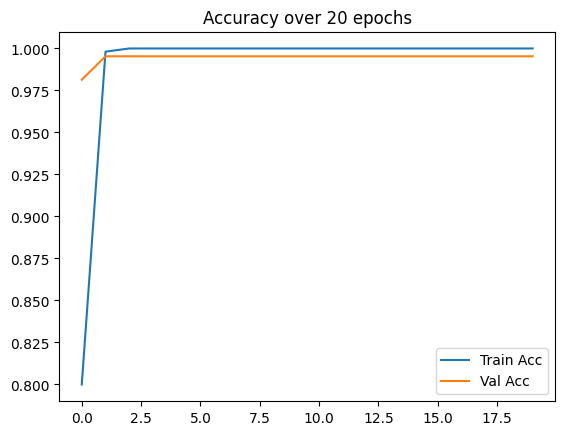

In [177]:
plt.title("Accuracy over 20 epochs")
plt.plot(range(20), history.history["accuracy"])
plt.plot(range(20), history.history["val_accuracy"])
plt.legend(["Train Acc", "Val Acc"])

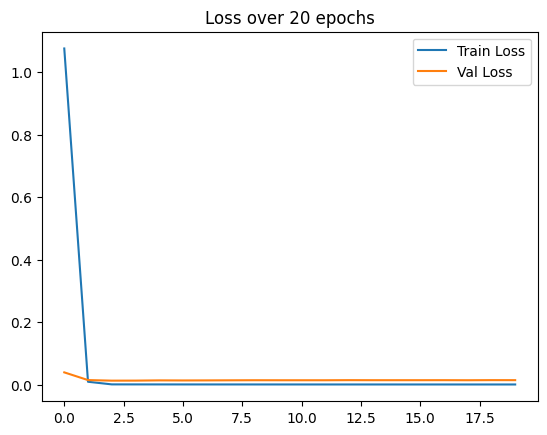

In [178]:
plt.title("Loss over 20 epochs")
plt.plot(range(20), history.history["loss"])
plt.plot(range(20), history.history["val_loss"])
plt.legend(["Train Loss", "Val Loss"])

16/16 [==============================] - 32s 2s/step


[Text(0.5, 1.0, 'Test set confusion matrix'),
 Text(0.5, 23.52222222222222, 'predicted label'),
 Text(50.722222222222214, 0.5, 'true label')]

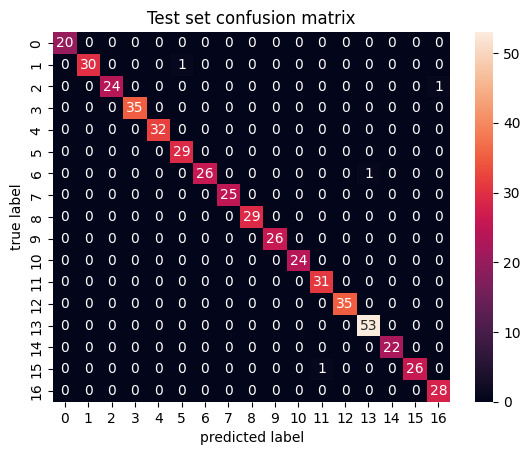

In [179]:
y_pred = model.predict(X_test)

y_true = np.argmax(y_test, axis=1)
y_pred_oh = np.argmax(y_pred, axis=1)

sns.heatmap(confusion_matrix(y_pred=y_pred_oh, y_true=y_true), annot=True, fmt='d').set(
    title='Test set confusion matrix', xlabel='predicted label', ylabel='true label')

### Model on New Data

Let's see how our model performs on new images. Here, we test two images of Natalie Portman, which get correctly identified (Natalie Portman was one of the 17 celebrities). We also test on an image of Leonardo DiCaprio, which gets correctly identified as well.

On an image of Channing Tatum, however, the model says that the person in the image cannot be identified. In the actual AI system created by Chandon Inc., this situation would rarely happen, as it has scraped billions of publicly available images from the internet. It will mostly only be unable to identify a person if that person has close to no pictures of themselves on the internet.

In [180]:
def decode_prediction(pred):
    
    if np.max(pred) < 0.7:
        print("Cannot identify the person")
        return
        
    print("The person is:", celeb_per_label[str(np.argmax(pred))], "; Softmax Probability:", np.max(pred))
    
    
def find_new_person(filename):
    face = extract_face(filename)
    plt.imshow(face)
    plt.show()

    face = face.astype(np.float32)
    samples = np.expand_dims(face, axis=0)
    samples = preprocess_input(samples, version=2)

    pred = model.predict(samples)
    decode_prediction(pred)
    
    
     

1/1 [==============================] - 0s 123ms/step


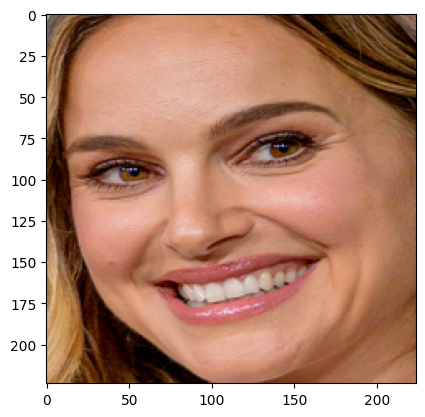

1/1 [==============================] - 0s 404ms/step
The person is: Natalie Portman ; Softmax Probability: 0.99999714
True label: Natalie Portman


In [181]:
find_new_person("test_images/natalie_portman.jpg")
print("True label: Natalie Portman")

1/1 [==============================] - 0s 139ms/step


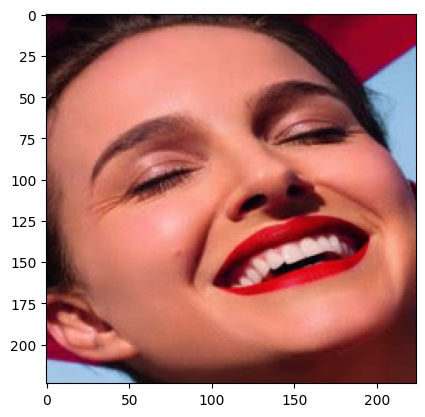

1/1 [==============================] - 0s 240ms/step
The person is: Natalie Portman ; Softmax Probability: 0.99999106
True label: Natalie Portman


In [182]:
find_new_person("test_images/natalie_portman2.jpg")
print("True label: Natalie Portman")

1/1 [==============================] - 0s 158ms/step


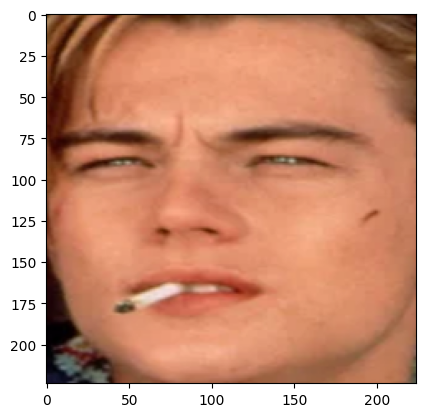

1/1 [==============================] - 0s 244ms/step
The person is: Leonardo DiCaprio ; Softmax Probability: 0.98926777
True label: Leonardo DiCaprio


In [183]:
find_new_person("test_images/leo_dicaprio1.jpg")
print("True label: Leonardo DiCaprio")

1/1 [==============================] - 0s 188ms/step


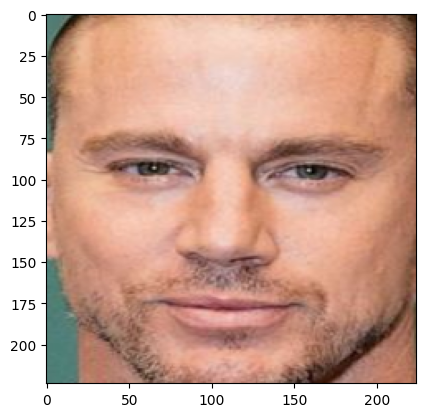

1/1 [==============================] - 0s 228ms/step
Cannot identify the person
True label: Channing Tatum


In [184]:
find_new_person("test_images/channing_tatum1.jpg")
print("True label: Channing Tatum")